In [54]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import umap
import random
from matplotlib.image import BboxImage
from matplotlib.transforms import Bbox, TransformedBbox
from sklearn.neighbors import KNeighborsClassifier
import pickle
from tqdm import tqdm
from utils import features_dpt_entropy, features_homology_dpt_entropy, features_vector, features_ripley_dpt_v2, preprocessing, features_avg_connection_dpt
import utils as util
import pandas as pd
import glob
from sklearn.decomposition import PCA
import simdata_generator as dataset
import os 
from sknetwork.clustering import Louvain
from sklearn.neighbors import kneighbors_graph
import scanpy_modified as scanpy
from anndata import AnnData
import scanpy as sp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Figure 2

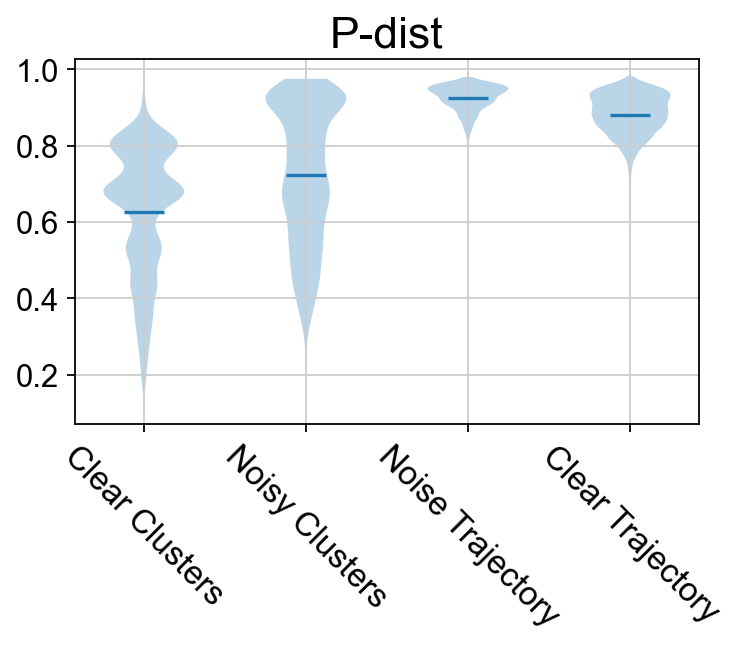

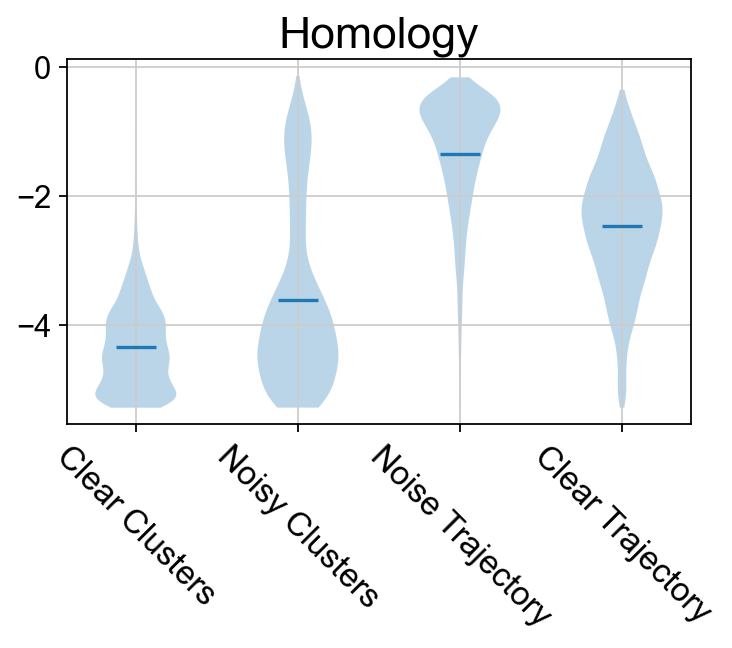

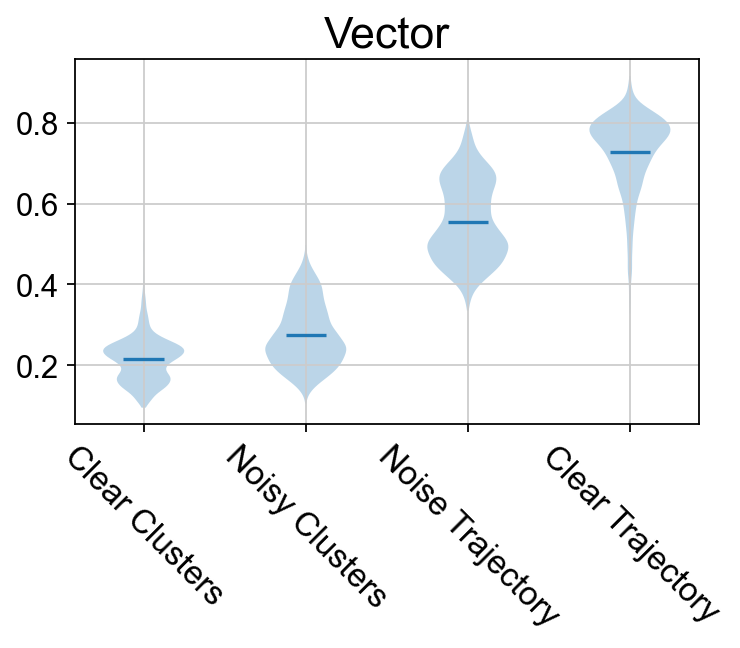

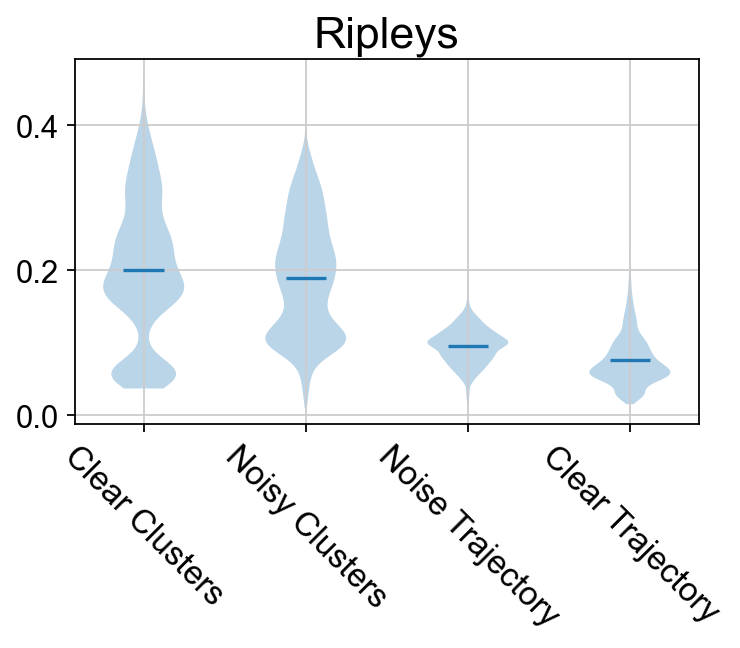

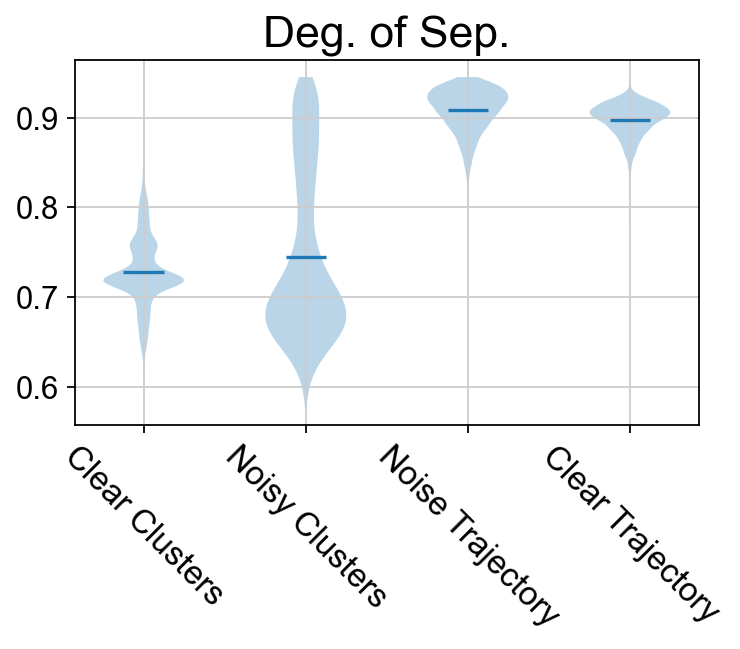

In [55]:
META_SCORES = list(np.load('data/simulated_metascores_12000.npy')) # Loading pre-computed scores for simulated datasets
repeat = 3000
clstr = META_SCORES[:repeat]
traj = META_SCORES[repeat:2*repeat]
clstr_r1 = META_SCORES[2*repeat:3*repeat]
traj_r1 = META_SCORES[3*repeat:4*repeat]

npy_sim = np.array(META_SCORES)
feature_names = ['P-dist','Homology','Vector','Ripleys','Deg. of Sep.']
for i in range(len(feature_names)):
    feat = i
    plt.figure(figsize=(5,3))
    plt.violinplot([np.array(clstr)[:,feat],
                    np.array(clstr_r1)[:,feat],
                    np.array(traj_r1)[:,feat],
                    np.array(traj)[:,feat]],
                  showmeans = True, showextrema=False)
    plt.title(feature_names[i], fontsize = 20)
    plt.xticks(fontsize=15, rotation=315)
    plt.xticks([1, 2, 3, 4], ['Clear Clusters','Noisy Clusters','Noise Trajectory','Clear Trajectory'])
    plt.show()

## Figure 3

/Users/lim/opt/anaconda3/envs/scVenv/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


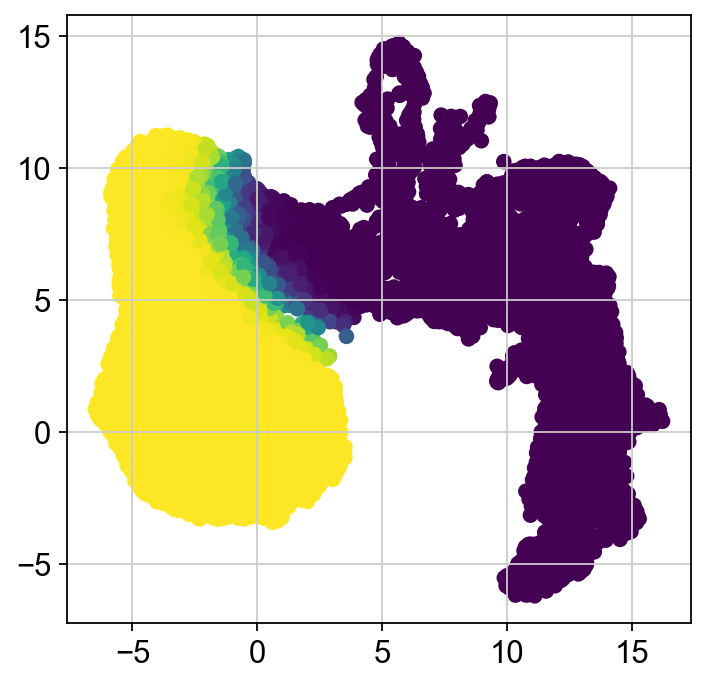

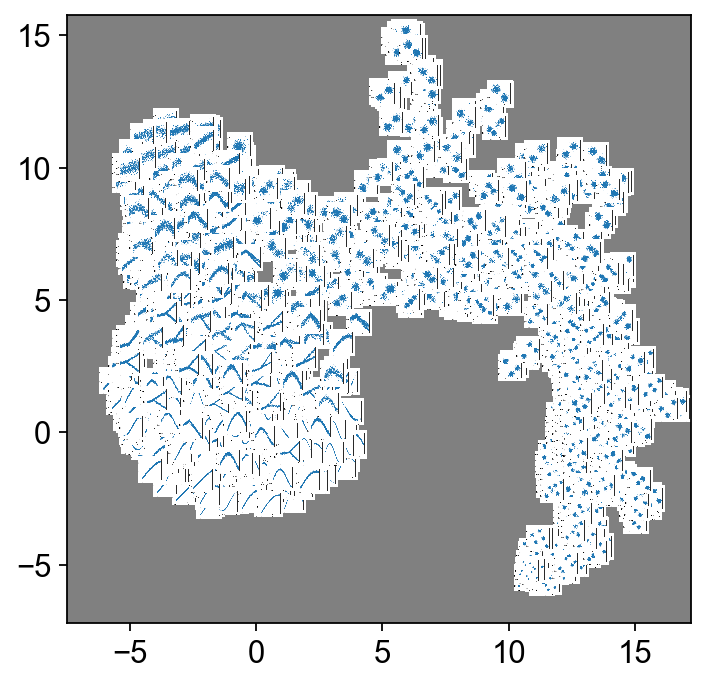

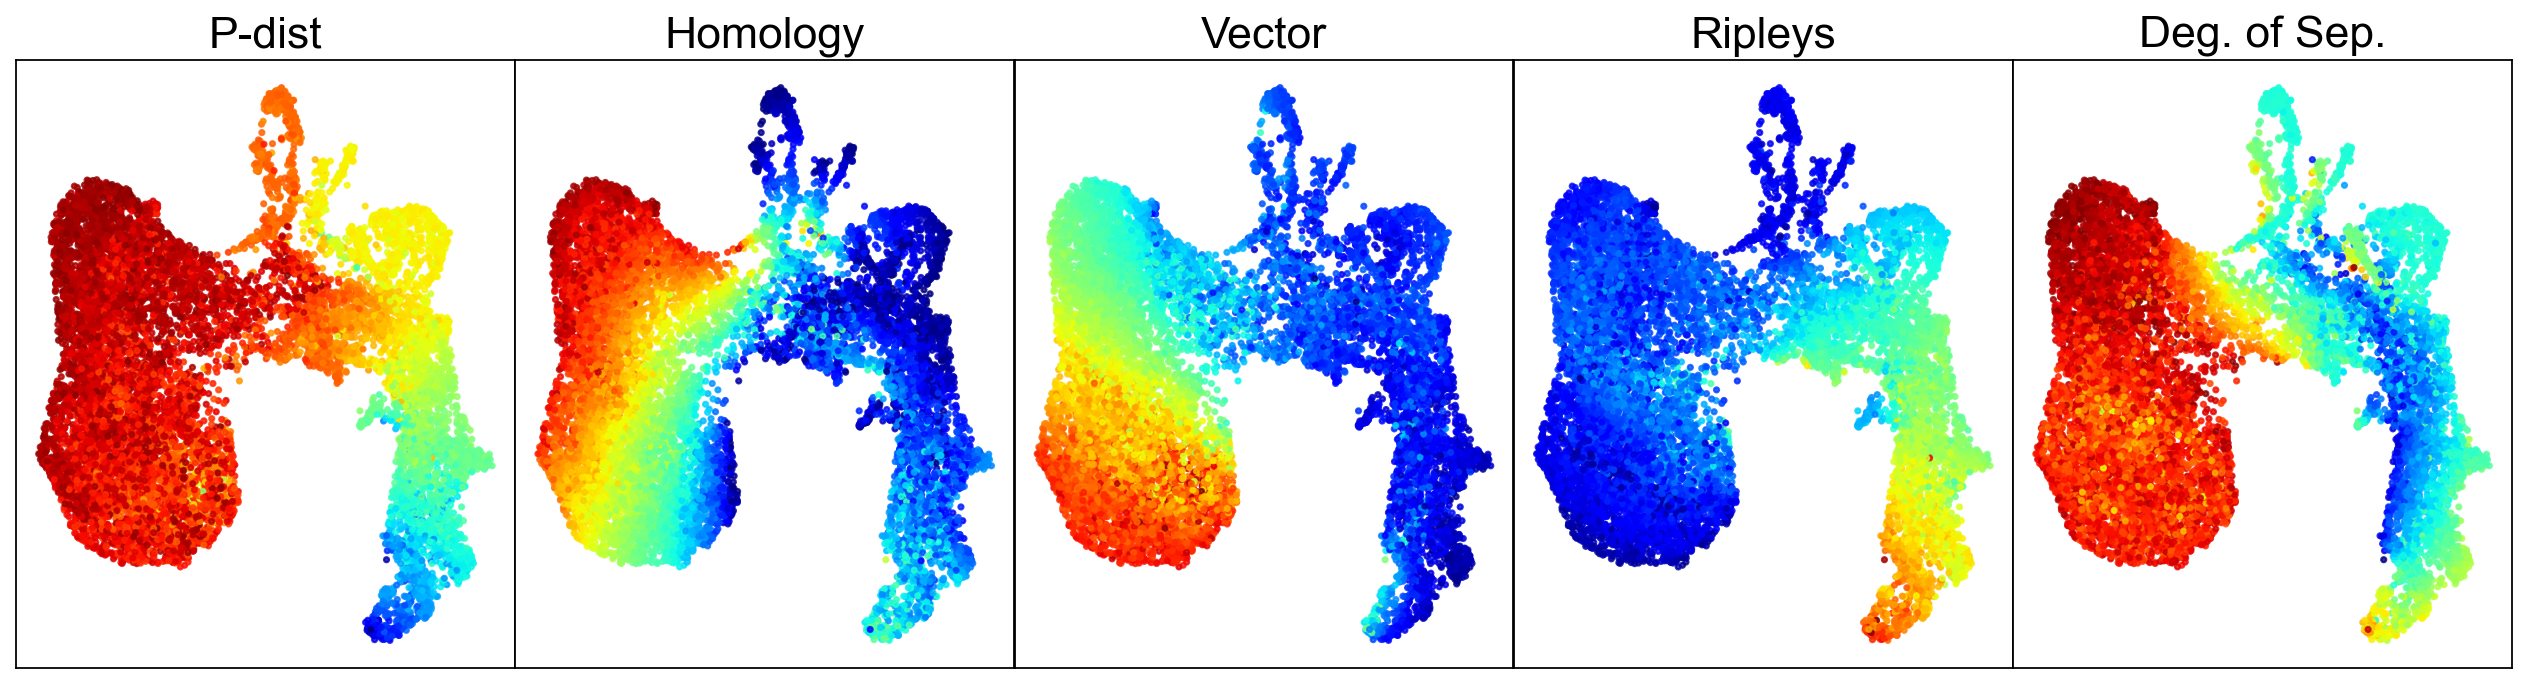

In [56]:
metric = 'euclidean'
seed = 1
n_neighbors = 50
min_dist = 0.6
figsize = 5

scaler = StandardScaler()
tmp_np = scaler.fit_transform(npy_sim)
tmp_reducer = umap.UMAP(n_neighbors=n_neighbors, n_components=2,random_state=seed,min_dist=min_dist, metric=metric)
embedding = tmp_reducer.fit_transform(tmp_np)

classes = ['Clear Clusters','Clear Trajectory','Noisy Trajectory','Noisy Clusters']
c1 = [0 for i in range(repeat)]
c2 = [1 for i in range(repeat)]
c3 = [0 for i in range(repeat)]
c4 = [1 for i in range(repeat)]

c = c1+c2+c3+c4

neigh = KNeighborsClassifier(n_neighbors=100)
neigh.fit(embedding, c)

b = neigh.predict(embedding)
p = neigh.predict_proba(embedding)[:,1]
plt.show()
plt.figure(figsize=(figsize,figsize))
plt.scatter(embedding[:,0],embedding[:,1], c = p, alpha = 1)
plt.show()

def plotImage(x, y, im):
    bb = Bbox.from_bounds(x,y,1,1)  
    bb2 = TransformedBbox(bb,ax.transData)
    bbox_image = BboxImage(bb2,
                        norm = None,
                        origin=None,
                        clip_on=False)

    bbox_image.set_data(im)
    ax.add_artist(bbox_image)

if os.path.exists('scatterplots'):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = fig.add_subplot(111)
    ax.grid()
    ax.set_facecolor('gray')
    for i in range(len(npy_sim)):
        if random.uniform(0, 1) < 0.1: 
            plotImage(embedding[i][0], embedding[i][1], plt.imread('scatterplots/{}.png'.format(i+1)))
        else:
            continue

    # Set the x and y limits
    border = 1
    ax.set_ylim(np.min(embedding, axis =0)[1]-border,np.max(embedding, axis =0)[1]+border)
    ax.set_xlim(np.min(embedding, axis =0)[0]-border,np.max(embedding, axis =0)[0]+border)
    plt.show()

fig, axs = plt.subplots(1,5, figsize=(20, 5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

for i in range(5):
    axs[i].scatter(embedding[:,0],embedding[:,1], s=5,c= npy_sim[:len(embedding),i], cmap = 'jet', alpha = 0.8)
    axs[i].set_title(feature_names[i], fontsize=20)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

## Figure 4

In [57]:
with open('data/real_data_dict.pkl', 'rb') as file:
    loaded_dict = pickle.load(file)
all_files = list(loaded_dict.keys())
scores = []
for f in all_files:
    scores.append(loaded_dict[f]['score'])
npy_real = np.array(scores)

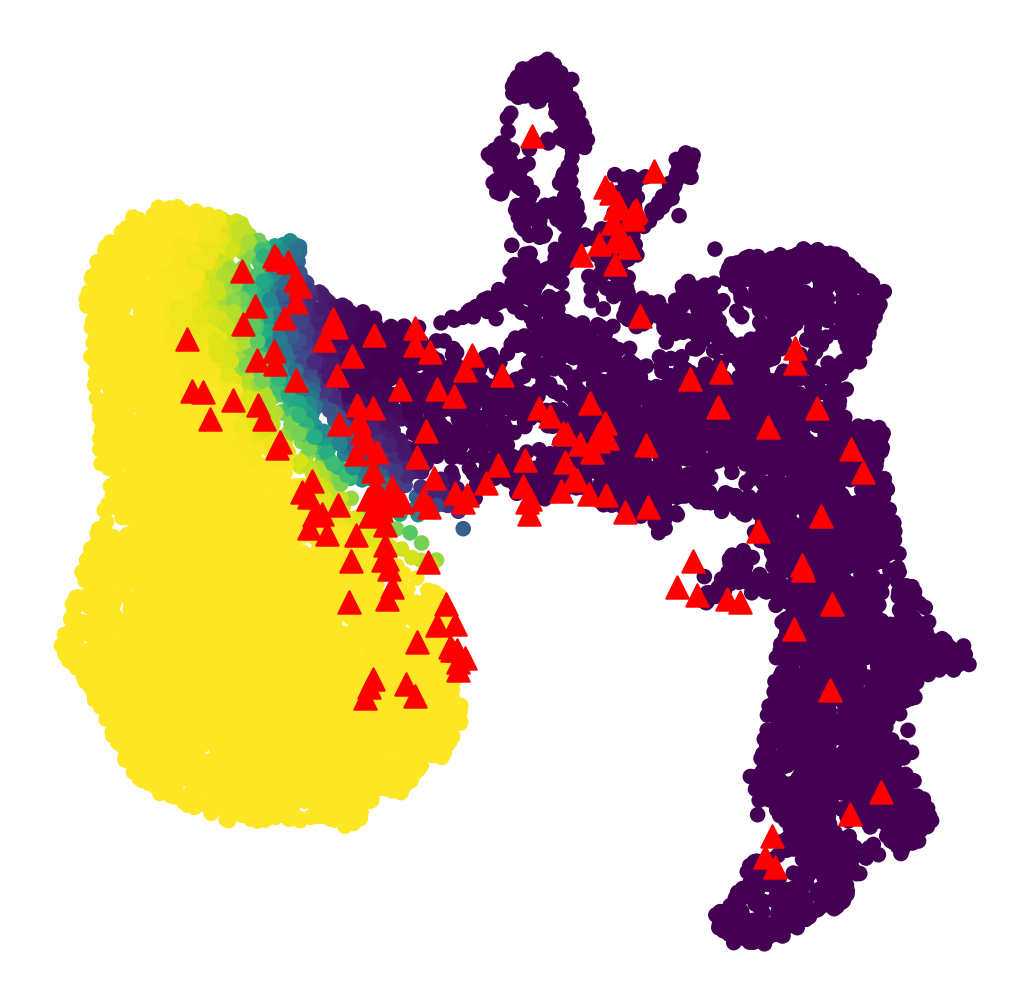

In [58]:

tmp_real = scaler.transform(npy_real)
np_real_emb = tmp_reducer.transform(tmp_real)

plt.figure(figsize=(8,8))
plt.scatter(embedding[:,0],embedding[:,1], c = p, alpha = 1)
plt.scatter(np_real_emb[:,0],np_real_emb[:,1], c = 'r', s = 100,  marker="^")
plt.axis('off')
plt.show()

In [62]:
np.sum(neigh.predict(np_real_emb))

/Users/lim/opt/anaconda3/envs/scVenv/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


55

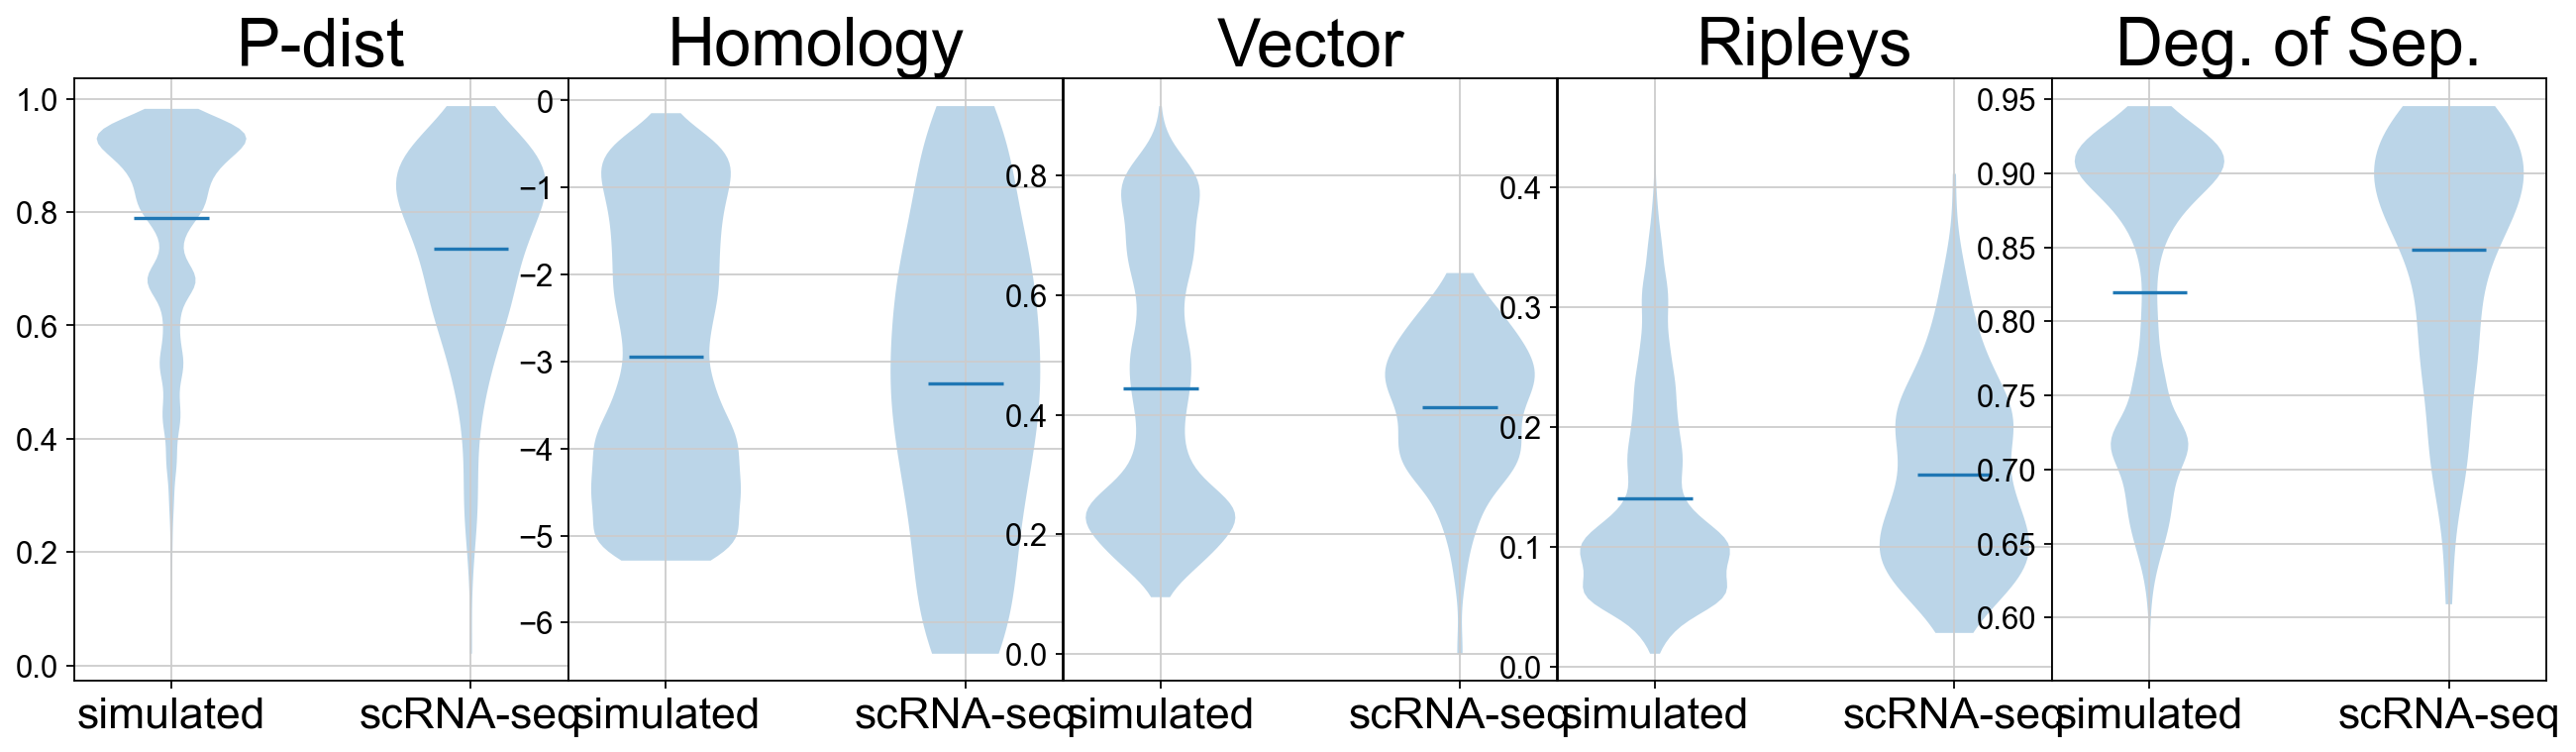

In [59]:
all_sims = np.vstack([np.array(clstr),
                    np.array(clstr_r1),
                    np.array(traj_r1),
                    np.array(traj)])
fig, axs = plt.subplots(1,5, figsize=(20, 5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()
for i in range(5):
    feat = i
    axs[i].violinplot([all_sims[:,feat],npy_real[:,feat]],
                  showmeans = True, showextrema=False)
    axs[i].set_xticks([1, 2], ['simulated','scRNA-seq'], fontsize=20)
    axs[i].set_title(feature_names[i],fontsize=30)
    

In [64]:
traj_type = []
for f in all_files:
    traj_type.append(loaded_dict[f]['data_type'])
COUNTS = []
for tt in np.unique(np.array(traj_type)):
    query = np.array([np_real_emb[np.array(traj_type) == tt,0],np_real_emb[np.array(traj_type) == tt,1]]).T
    prediction = neigh.predict(query)
    count_cluster=len(np.where(prediction==0)[0])
    count_traj=len(np.where(prediction==1)[0])

    COUNTS.append([count_cluster,count_traj])
fig4_c = pd.DataFrame(COUNTS,columns=['predicted clusters','predicted trajectory'],index = np.unique(np.array(traj_type)))
fig4_c

/Users/lim/opt/anaconda3/envs/scVenv/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/lim/opt/anaconda3/envs/scVenv/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value N

,predicted clusters,predicted trajectory
acyclic_graph,1,0
bifurcation,7,6
cluster,19,13
convergence,1,0
cycle,1,1
disconnected_graph,23,2
linear,17,22
multifurcation,7,2
organ,21,7
tree,17,2


In [65]:
fig4_c.sum()

predicted clusters      114
predicted trajectory     55
dtype: int64

## FIGURE 5

In [46]:
subcluster_scores = pd.read_csv('data/subcluster_scores.csv',index_col = 0)
npy_subcluster_scores = subcluster_scores.values
sub_emb = []
tmp_real = scaler.transform(npy_subcluster_scores)
np_sub_emb = tmp_reducer.transform(tmp_real)
    

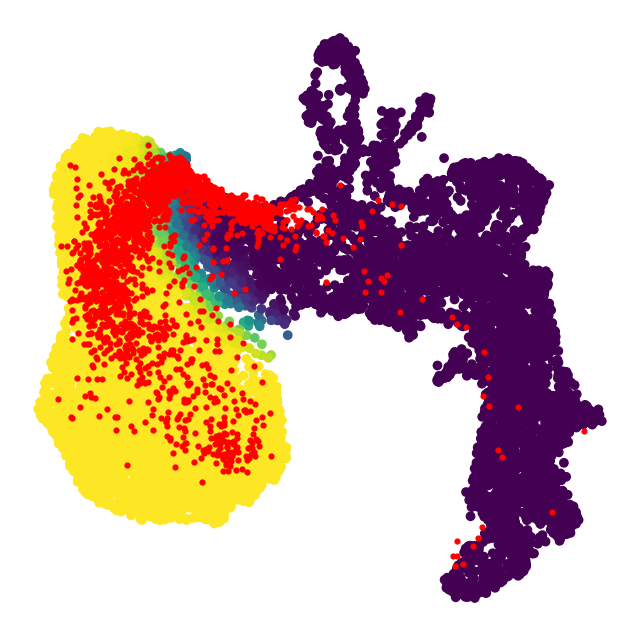

In [47]:
#np_sub_emb = np.load('data/sub_cluster_embedding.npy')
plt.figure(figsize=(8,8))
plt.scatter(embedding[:,0],embedding[:,1], c = p, alpha = 1)
plt.scatter(np_sub_emb[:,0],np_sub_emb[:,1], c = 'r', s = 12)
plt.axis('off')
plt.show()

100%|██████████| 11/11 [00:08<00:00,  1.34it/s]


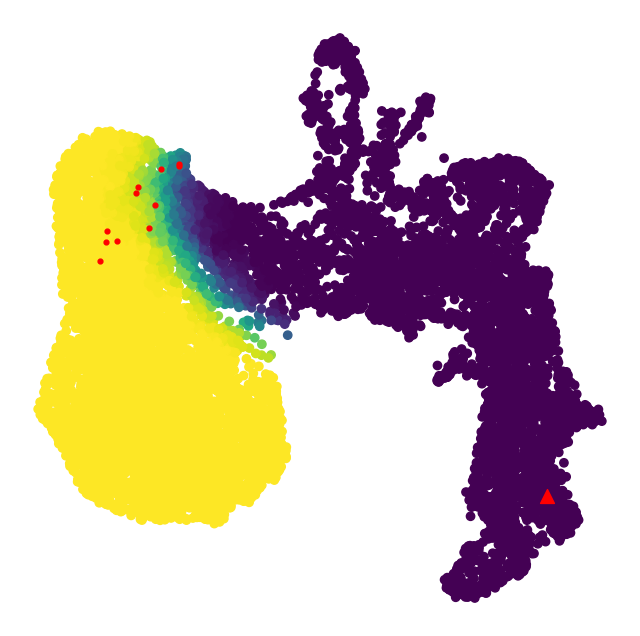

100%|██████████| 7/7 [00:04<00:00,  1.57it/s]


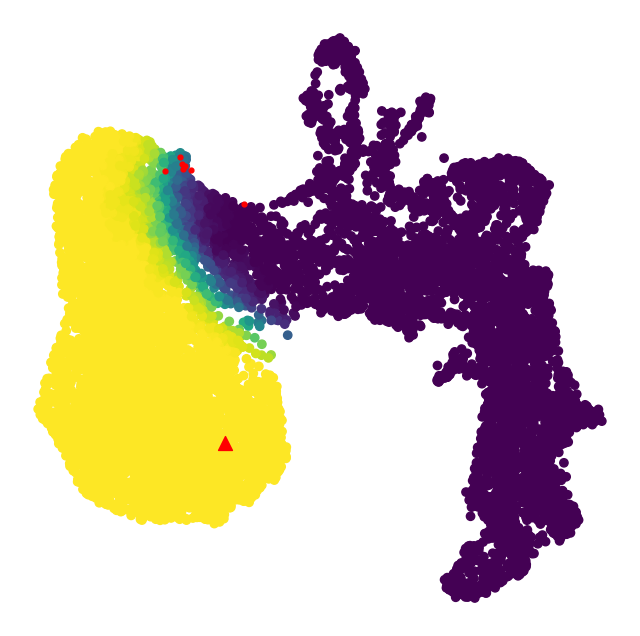

In [48]:
subnames = list(subcluster_scores.index)

nm = 'data/benchmarkfiles\mouse-cell-atlas-combination-1.rds.csv'
example_scores1 = subcluster_scores.loc[nm]
npy_subcluster_example1 = example_scores1.values
sub_emb_exp1 = []
for i in tqdm(range(len(npy_subcluster_example1))):
    tmp_real = scaler.transform(npy_subcluster_example1[i,:].reshape(1, -1))
    d2_real_embedding = tmp_reducer.transform(tmp_real.reshape(1, -1))
    sub_emb_exp1.append(d2_real_embedding)

np_sub_emb_exp1 = np.array(sub_emb_exp1)
np_sub_emb_exp1 = np_sub_emb_exp1.reshape((len(sub_emb_exp1),2))
plt.figure(figsize=(8,8))
plt.scatter(embedding[:,0],embedding[:,1], c = p, alpha = 1)
plt.scatter(np_sub_emb_exp1[:,0],np_sub_emb_exp1[:,1], c = 'r', s = 12)
idx = all_files.index('mouse-cell-atlas-combination-1')
plt.scatter(np_real_emb[idx,0],np_real_emb[idx,1], c = 'r', s = 100, marker="^")

plt.axis('off')
plt.show()

nm = 'data/benchmarkfiles\embryonic-mesenchyme-stromal-cell-cxcl14-cxcl12-axis_mca.rds.csv'
example_scores1 = subcluster_scores.loc[nm]
npy_subcluster_example1 = example_scores1.values
sub_emb_exp1 = []
for i in tqdm(range(len(npy_subcluster_example1))):
    tmp_real = scaler.transform(npy_subcluster_example1[i,:].reshape(1, -1))
    d2_real_embedding = tmp_reducer.transform(tmp_real.reshape(1, -1))
    sub_emb_exp1.append(d2_real_embedding)

np_sub_emb_exp1 = np.array(sub_emb_exp1)
np_sub_emb_exp1 = np_sub_emb_exp1.reshape((len(sub_emb_exp1),2))
plt.figure(figsize=(8,8))
plt.scatter(embedding[:,0],embedding[:,1], c = p, alpha = 1)
plt.scatter(np_sub_emb_exp1[:,0],np_sub_emb_exp1[:,1], c = 'r', s = 12)
idx = all_files.index('embryonic-mesenchyme-stromal-cell-cxcl14-cxcl12-axis_mca')
plt.scatter(np_real_emb[idx,0],np_real_emb[idx,1], c = 'r', s = 100, marker="^")

plt.axis('off')
plt.show()


## FIGURE 6 and 7

In [49]:
def load_fig6_7_data(pca_dim = 20):
    files = glob.glob("data/fig6_fig7/*.csv")
    df_real = []
    for file in tqdm(files,position=0, leave=True):
        df = pd.read_csv(file, index_col=0)
        npy_array = np.array(df)
        pca = PCA(n_components=pca_dim,random_state=42)
        embedding = pca.fit_transform(npy_array)
        df_real.append(embedding)
    return df_real, files

In [50]:
files = glob.glob('data/fig6_fig7/*.csv')
dfs_fig6_7,names = load_fig6_7_data()
score_fig6_7 = []
for d in dfs_fig6_7:
    score_fig6_7.append(util.scoring(d))

100%|██████████| 8/8 [00:08<00:00,  1.08s/it]


In [51]:
npy_67 = np.array(score_fig6_7)
real_embs_67 = []
for i in range(len(npy_67)):
    tmp_real = scaler.transform(npy_67[i,:].reshape(1, -1))
    d2_real_embedding = tmp_reducer.transform(tmp_real.reshape(1, -1))
    real_embs_67.append(d2_real_embedding)

np_real_emb_67 = np.array(real_embs_67)
np_real_emb_67 = np_real_emb_67.reshape((len(real_embs_67),2))

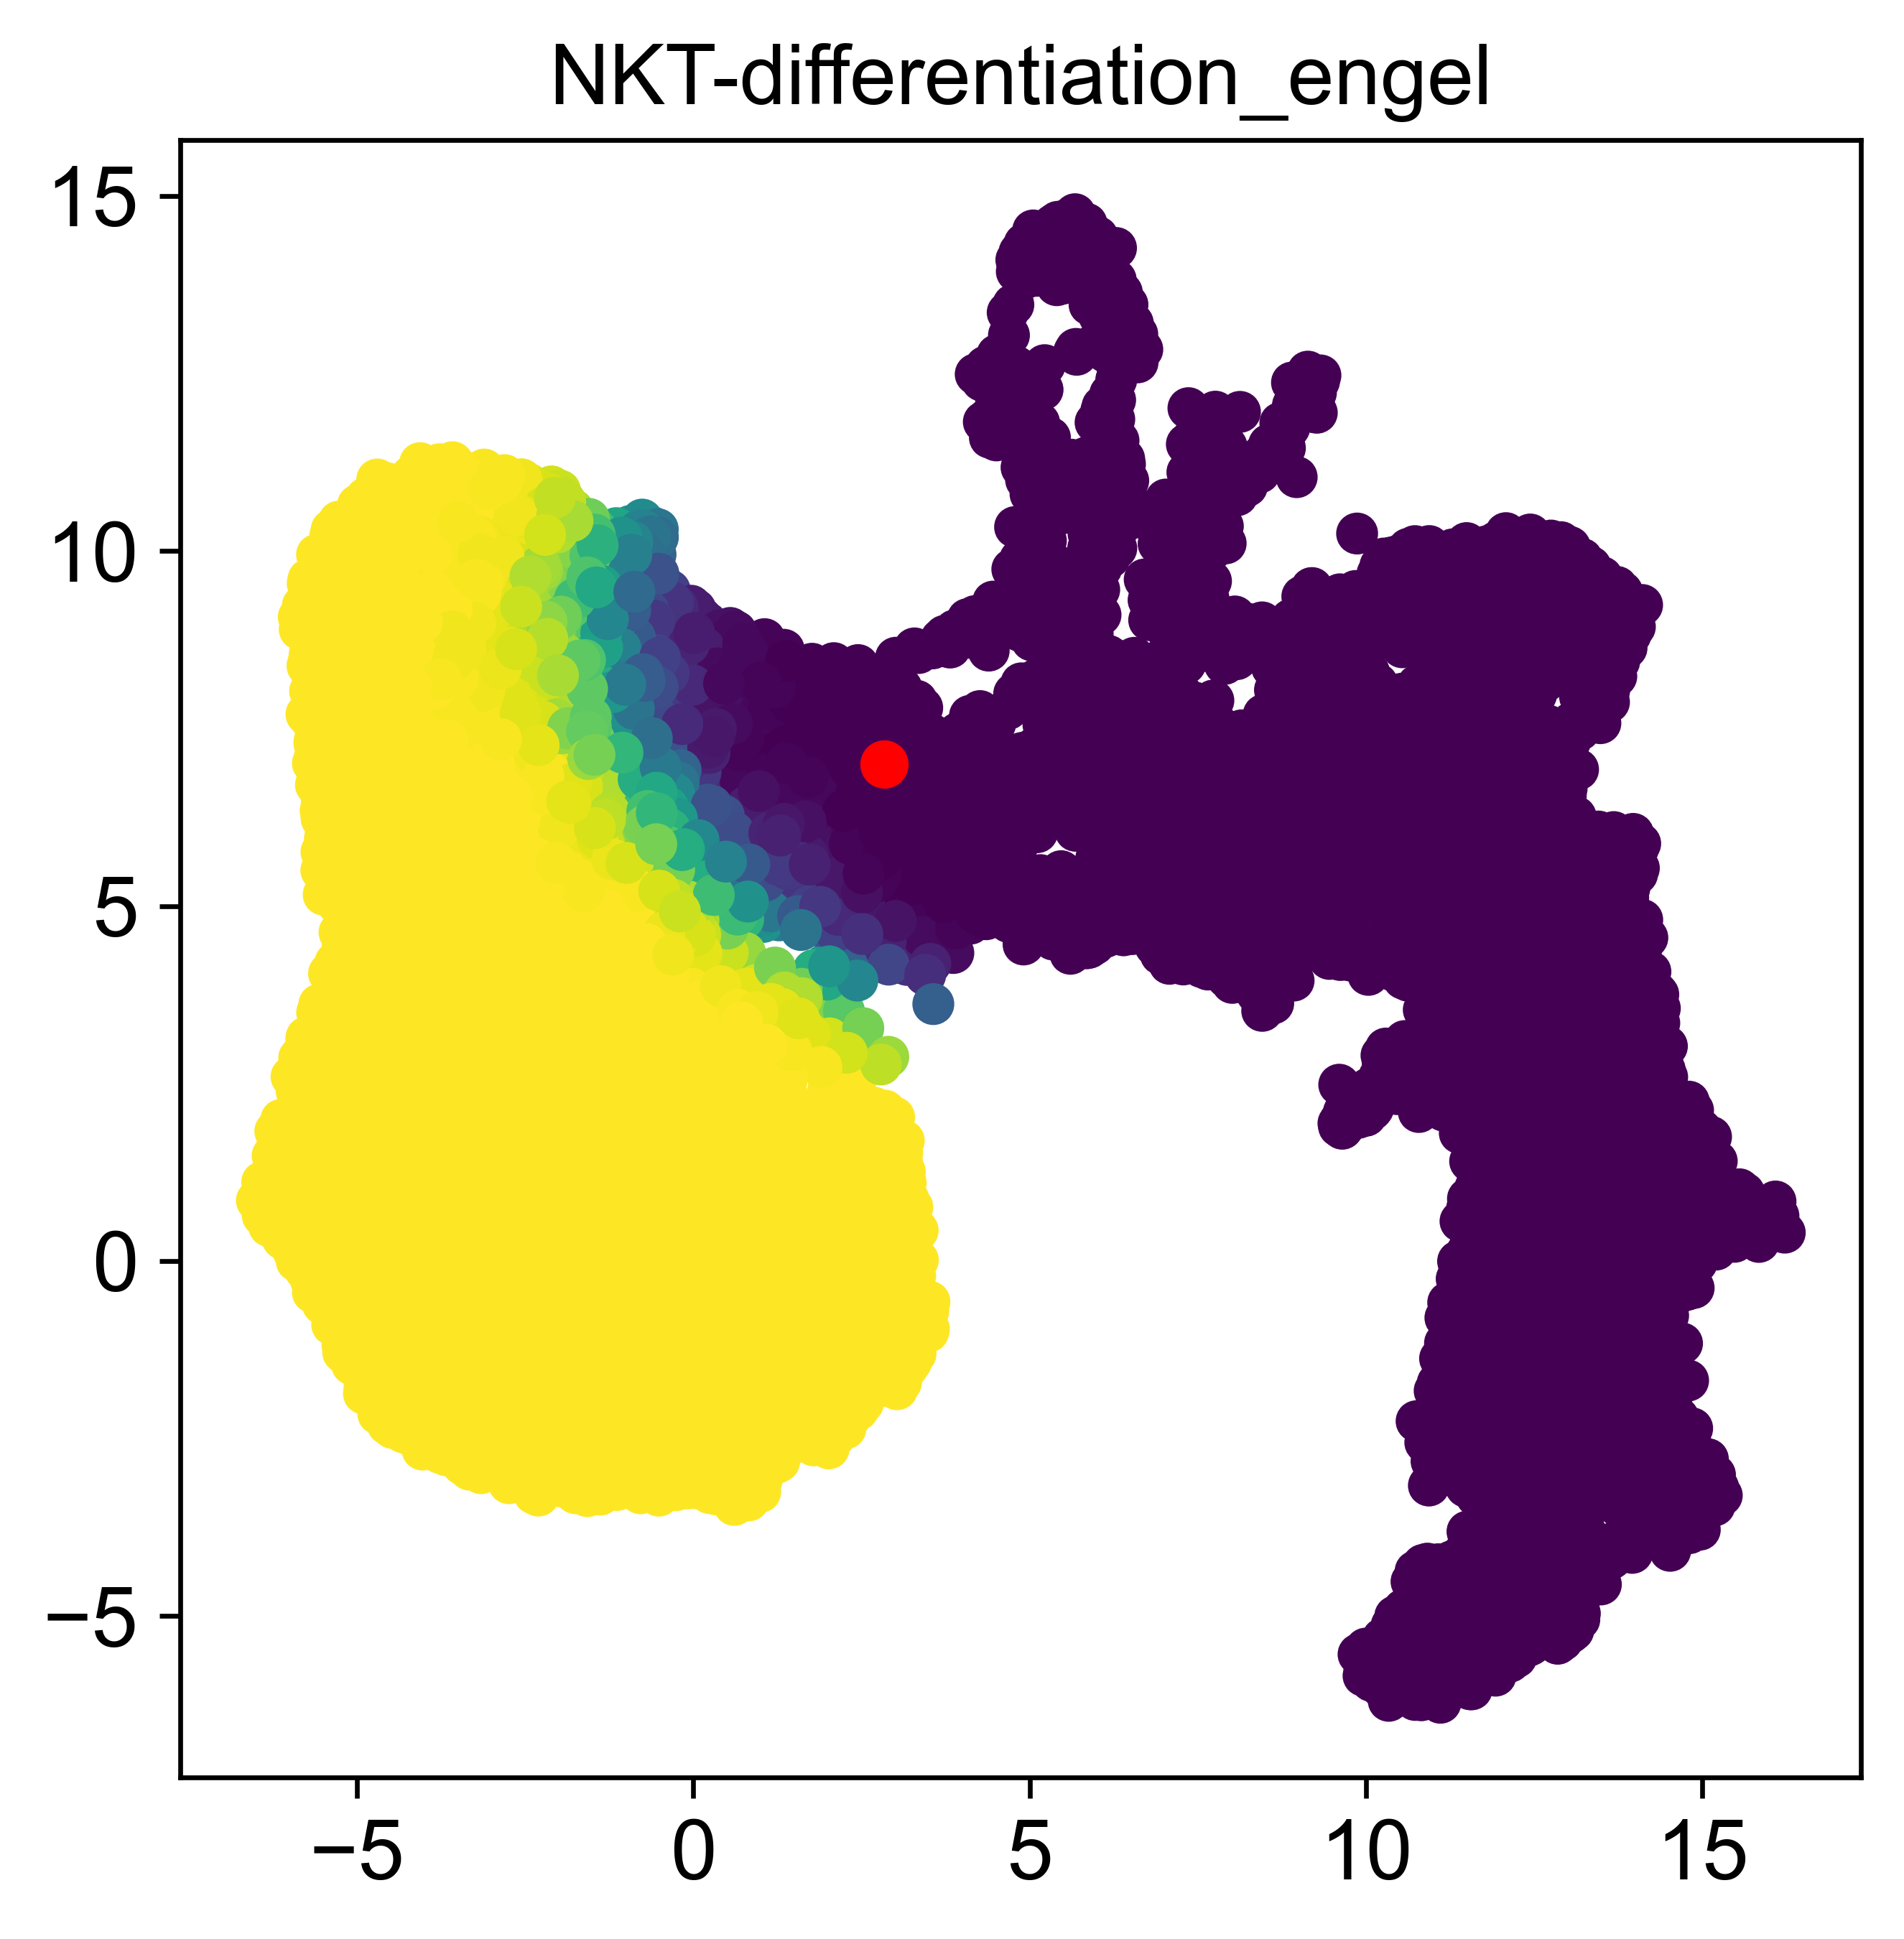

<Figure size 640x640 with 0 Axes>

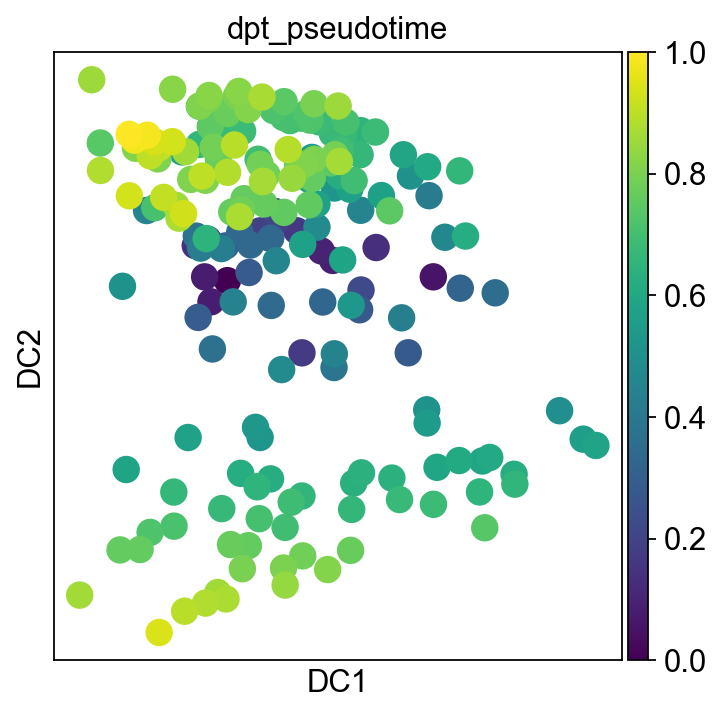

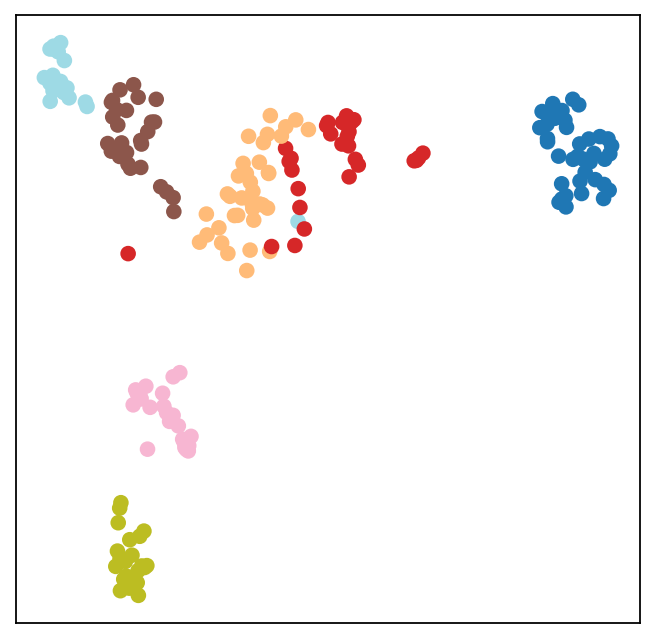

--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=


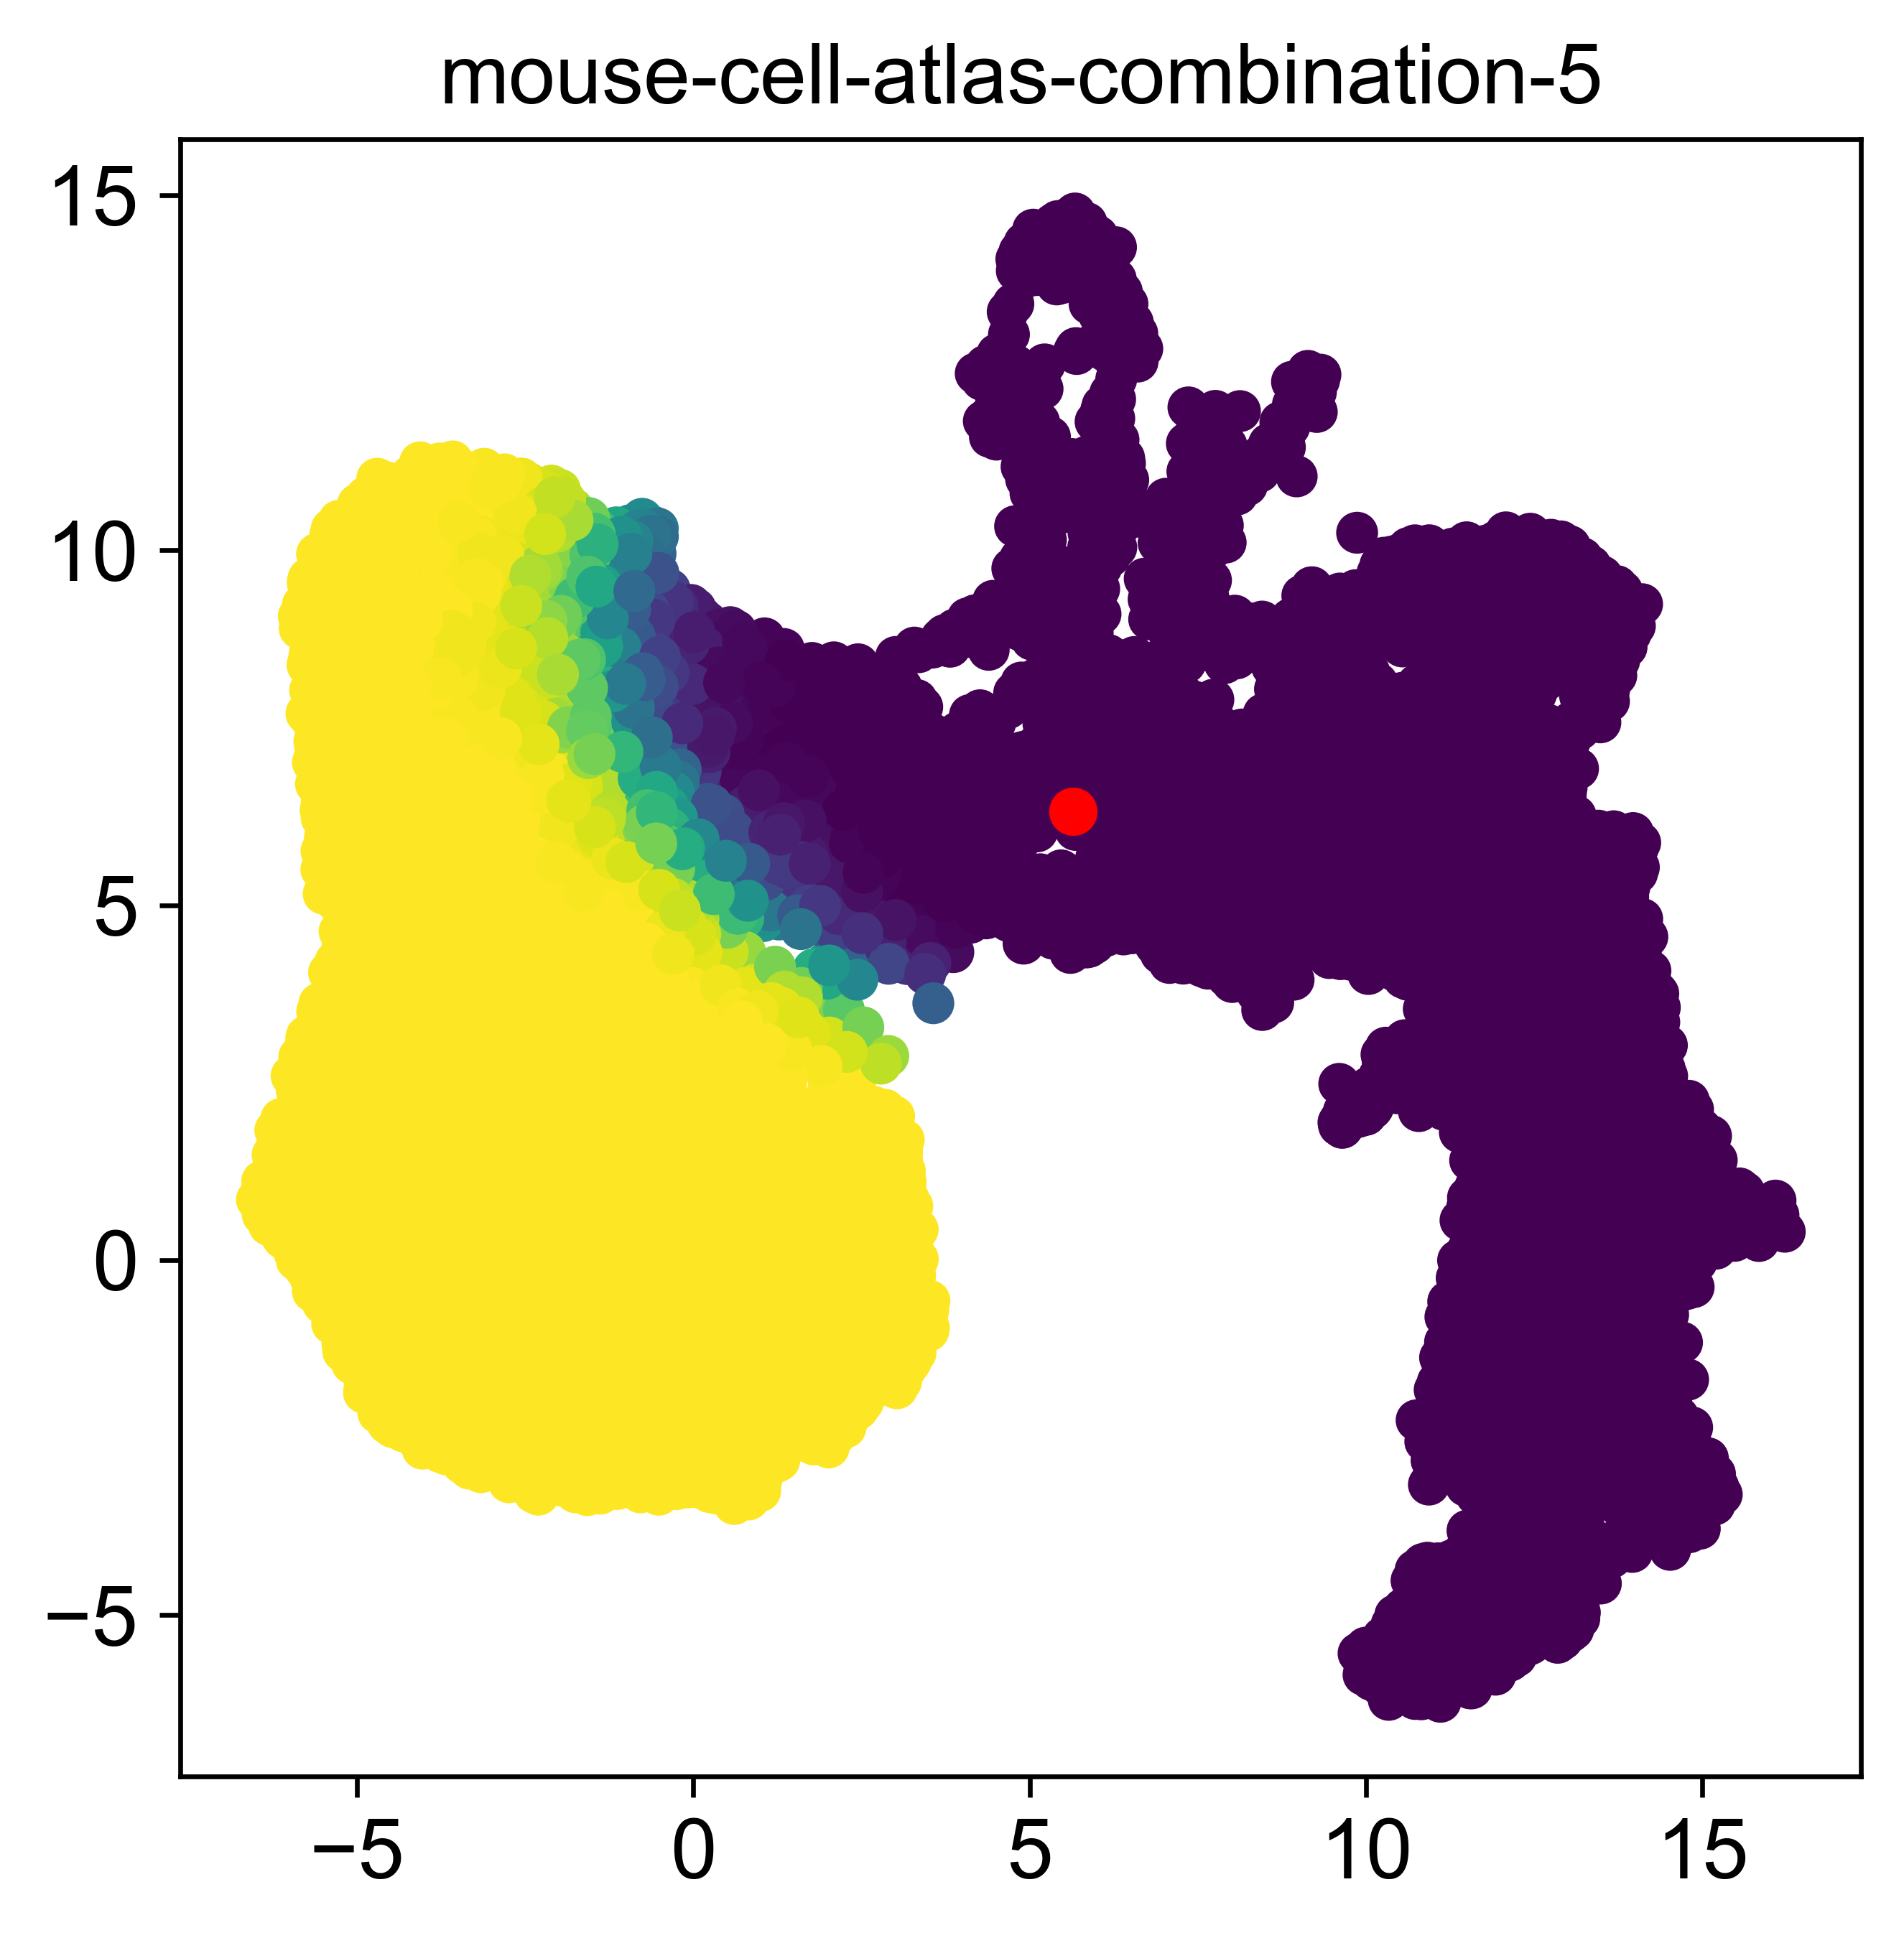

In [66]:
#
for i in range(len(files)):
        plt.figure(figsize=(5,5),dpi=300)
        plt.scatter(embedding[:,0],embedding[:,1], c = p, alpha = 1)
        plt.scatter(np_real_emb_67[i,0],np_real_emb_67[i,1], c = 'r', s = 50)
        plt.title(names[i].split('/')[-1].split('.rds')[0])
        plt.grid(None)
        plt.show()

        df = pd.read_csv(files[i], index_col=0)
        df = preprocessing(np.array(df))
        data = np.array(df)
        data = AnnData(data)
        data.uns['iroot'] = 0 
        plt.figure(figsize=(8,8))
        sp.set_figure_params(dpi=80, dpi_save=150, figsize=(5,5))
        sp.tl.pca(data, svd_solver='arpack')
        sp.pp.neighbors(data)
        sp.tl.diffmap(data)
        sp.tl.dpt(data)
        sp.pl.diffmap(data,color=['dpt_pseudotime'])

        pca = PCA(n_components=20)
        embedding_pca = pca.fit_transform(df)
        A = kneighbors_graph(embedding_pca, 10, mode='connectivity', include_self=True)
        louvain = Louvain()
        labels = louvain.fit_transform(A)
        Umap = umap.UMAP()
        embedding_umap = Umap.fit_transform(embedding_pca)
        fig = plt.figure(figsize=(5,5))
        plt.scatter(embedding_umap[:,0],embedding_umap[:,1],c=labels, alpha=1, cmap='tab20')
        plt.xticks([])
        plt.yticks([])
        plt.show()
        print('--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=')